# Connecting Workspace and Creating Experiment

In [1]:
import azureml.core
from azureml.core import Workspace
ws = Workspace.from_config()

print("Azure ML SDK Version: ", azureml.core.VERSION)
print(ws.name, ws.location, ws.resource_group, sep='\t')

Azure ML SDK Version:  1.7.0
msa-practice	australiaeast	msa-practice


In [2]:
from azureml.core import Experiment

exp_name = "clickbait"
experiment = Experiment(workspace=ws, name=exp_name)

# Load Data and Preprocessing

Load dataset from "clickbait_data.csv" - contains 32000 titles of articles, each assigned a binary label indicating whether it is clickbait (0: not clickbait, 1: clickbait). Each category hsa 16000 titles. Verify that there are no missing values in dataset. Then, preprocess each line by converting each line to lowercase, strip all punctuation, and replace numbers with a identifier.

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("clickbait_data.csv")
print(df.columns)
df.head(10)

# Check for NA values - none found
print("Empty values:")
print(df.isnull().sum())

Index(['headline', 'clickbait'], dtype='object')
Empty values:
headline     0
clickbait    0
dtype: int64


In [4]:
def process(line):
    import re, string
    
    #To lowercase
    line = line.lower()
    
    # Remove punctuation
    line = line.translate(line.maketrans('','', string.punctuation))
    
    # Replace digits
    line = re.sub('\d+', 'num', line)
    
    return line

# Preprocess each line
for (idx, (headline, _)) in df.iterrows():
    newline = process(headline)
    df.iloc[idx, 0] = newline

df.head(10)

,headline,clickbait
0,should i get bings,1
1,which tv female friend group do you belong in,1
2,the new star wars the force awakens trailer is...,1
3,this vine of new york on celebrity big brother...,1
4,a couple did a stunning photo shoot with their...,1
5,how to flirt with queer girls without making a...,1
6,num cute things to distract from your awkward ...,1
7,if disney princesses were from florida,1
8,whats a quote or lyric that best describes you...,1
9,natalie dormer and sam claflin play a game to ...,1


Split dataset into 80% training data and 20% validation data

In [5]:
from sklearn.model_selection import train_test_split

df_x = df.copy()
df_y = df_x.pop('clickbait')
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2)

print(X_train[0:10])
print(X_test[0:10])

# Convert dataframe to numpy array
X_train_original = np.squeeze(X_train.values)
X_test_original = np.squeeze(X_test.values)
y_train = y_train.values
y_test = y_test.values

                                                headline
8991       men wore makeup for a week and looked glam af
24900  samples being taken from poultry farms in east...
264    which male actor should you get for christmas ...
8529                      are you more target or walmart
17408  num of secondary school students in ireland dr...
26665      student set for sentencing in failed bombings
29292                china will reopen tibet to tourists
8022   nums best news bloopers are here and theyre ou...
12604           british people guess posh crisp flavours
9318   num cookie lyon greeting cards for every occasion
                                                headline
6719           are you a sane person in a world gone mad
3595   the us mens gymnastics team is so hot its prob...
16605               new report details strain on us army
30206     ten children killed in estonian orphanage fire
12230            num pets with no damn respect for books
9712   whitney port from the hi

# Training Model

Train a fully-connected 3 layer neural network with Adam optimizer.

In [51]:
def create_model(top_words, title_length, dr):
    from keras.models import Sequential
    from keras.layers import Dense, Dropout
    from keras.layers.embeddings import Embedding
    from keras.layers import Flatten

    embedding_vector_length = 32
    model = Sequential()
    model.add(Embedding(top_words, embedding_vector_length, input_length=title_length))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(dr))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(dr))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    return model

Extract most common words and convert titles into numeric data

In [69]:
# Extract most common words
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing import sequence

top_words = 10000
X_train = X_train_original.copy()
X_test = X_test_original.copy()

title_length = 20

model = create_model(top_words, title_length, 0.0)
tokenizer = Tokenizer(num_words=top_words, filters='', oov_token=True)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

print("Training: \n{} \n\n Testing: \n{}\n".format(X_train[0:5], X_test[0:5]))

# Convert string title to sequences
X_train = sequence.pad_sequences(X_train, maxlen=title_length)
X_test = sequence.pad_sequences(X_test, maxlen=title_length)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)

if (not os.path.exists("models")): os.mkdir("models/")
    
model_name = "model_topwords_" + str(top_words)
model.save(model_name)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 20, 32)            320000    
_________________________________________________________________
flatten_18 (Flatten)         (None, 640)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 16)                10256     
_________________________________________________________________
dropout_29 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_30 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 1)               

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25600 samples, validate on 6400 samples
Epoch 1/5
25600/25600 [==============================] - 1s 27us/step - loss: 0.2548 - accuracy: 0.8895 - val_loss: 0.0765 - val_accuracy: 0.9725
Epoch 2/5
25600/25600 [==============================] - 1s 21us/step - loss: 0.0390 - accuracy: 0.9868 - val_loss: 0.0773 - val_accuracy: 0.9723
Epoch 3/5
25600/25600 [==============================] - 1s 21us/step - loss: 0.0127 - accuracy: 0.9968 - val_loss: 0.0732 - val_accuracy: 0.9762
Epoch 4/5
25600/25600 [==============================] - 1s 22us/step - loss: 0.0045 - accuracy: 0.9993 - val_loss: 0.0785 - val_accuracy: 0.9745
Epoch 5/5
25600/25600 [==============================] - 1s 20us/step - loss: 0.0019 - accuracy: 0.9998 - val_loss: 0.0835 - val_accuracy: 0.9752


# Evaluating Model

Visualising metrics - loss and accuracy curves, and confusion matrix

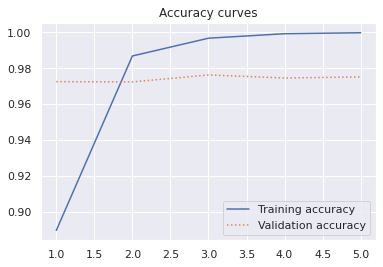

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val_acc, ':', label='Validation accuracy')
plt.legend()
plt.title("Accuracy curves")
plt.show()

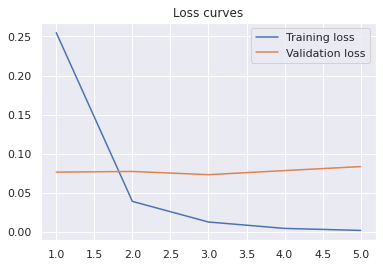

In [71]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, '-', label="Training loss")
plt.plot(epochs, val_loss, '-', label="Validation loss")
plt.legend()
plt.title("Loss curves")
plt.show()

In [72]:
from sklearn.metrics import classification_report

y_pred = (model.predict(X_test) > 0.5)
cm = confusion_matrix(y_pred, y_test)
crep = classification_report(y_pred, y_test)

print(cm)
print(crep)

[[3105   91]
 [  68 3136]]
              precision    recall  f1-score   support

       False       0.98      0.97      0.98      3196
        True       0.97      0.98      0.98      3204

   micro avg       0.98      0.98      0.98      6400
   macro avg       0.98      0.98      0.98      6400
weighted avg       0.98      0.98      0.98      6400



In [73]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 97.52%


# Making Predictions

Example predictions

In [85]:
def preprocess_line(text, tk):
    print(text)
    text = process(text)
    text = tokenizer.texts_to_sequences([text])
    #print("Tokenised text: ", text)
    text = sequence.pad_sequences(text, maxlen=title_length)
    return text

def predict_input(text):
    prediction = model.predict(preprocess_line(text, tokenizer))
    output = "Yes" if (prediction > 0.5) else "No"
    print("Likelihood of title clickbait: {}%".format(prediction*100))
    print("Is it clickbait? {}".format(output))

In [86]:
ex1 = r"21 More Movies That People Say Are Just Plain Better Than The Books They Were Based On"
ex2 = r"Deputy Chief Medical Officer says Victorian coronavirus outbreak is 'not a second wave'"

predict_input(ex1)
predict_input(ex2)

21 More Movies That People Say Are Just Plain Better Than The Books They Were Based On
Likelihood of title clickbait: [[99.7574]]%
Is it clickbait? Yes
Deputy Chief Medical Officer says Victorian coronavirus outbreak is 'not a second wave'
Likelihood of title clickbait: [[5.821718e-05]]%
Is it clickbait? No


In [87]:
text = input("Enter a title: ")
predict_input(text)

Enter a title:  Deputy Chief Medical Officer says Victorian coronavirus outbreak is 'not a second wave'


Deputy Chief Medical Officer says Victorian coronavirus outbreak is 'not a second wave'
Likelihood of title clickbait: [[5.821718e-05]]%
Is it clickbait? No
